In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from util import *

import time
import progressbar
bar = progressbar.ProgressBar(maxval=20, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])


## Load the COMPAS dataset

In [4]:
# Load COMPAS data
X,y,sensitive_features = load_compas_X_y_s(datasets)

# Split dataset into 4 sub-groups and retrieve the indices
subgroups_indices = get_lable_group_index(X, y, sensitive_features)

## Define a model for the study of long-term impact of fairness contraints in COMPAS

### Initial qualification rates
We randomly sample beginning points from 0 to 1. As shown in the following figure. 

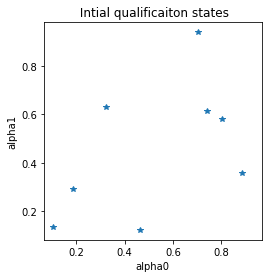

In [5]:
# Define the start point of qualification rates
np.random.seed(777)

NUM_SAMPLES = 8
P0 = 0.8
alpha0List = np.random.uniform(0.05,0.95,NUM_SAMPLES)
alpha1List = np.random.uniform(0.05,0.95,NUM_SAMPLES)


plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot(alpha0List,alpha1List,'*',label='Initial points')

plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.axis('square')
plt.title(" Intial qualificaiton states")
plt.show()

### Transition probability 
-  $P(Y_{t+1} = 1 \mid Y_t = y, A_t = a, S=s)$, represented by an array T[ y, a, s]: the probability to be qualified given the current qualification state $Y_t=y$, decision $A_t = a$, and the group $S=s$, i.e.,
- The following defined transition is under Condition 1(ii) in the paper.


In [6]:
# Define the transition matrix under Condition 1(ii)
# The order of index in T: 
# ["qualification state", "decision", "group"]
T = np.zeros((2, 2, 2))
T[0,0,0] = 0.5
T[0,1,0] = 0.6
T[1,0,0] = 0.6
T[1,1,0] = 0.9

T[0,0,1] = 0.2 # "Caucasian"
T[0,1,1] = 0.4
T[1,0,1] = 0.4
T[1,1,1] = 0.6


### Dynamics
$\alpha^s_{t+1} = g^{0s}_t + (g^{1s}_t-g^{0s}_t) \alpha^s_t$.  
- $g^{0s}_t = T[0,0,s]\mathbb{E}_{X\mid 0,s}(\hat{Y} = 0) + T[0,1,s] \mathbb{E}_{X\mid 0,s}(\hat{Y} = 1)$  
- $g^{1s}_t = T[1,0,s] \mathbb{E}_{X\mid 1,s}(\hat{Y} = 0) + T[1,1,s] \mathbb{E}_{X\mid 1,s}(\hat{Y} = 1)$
- T[ y, a, s] represents $P(Y_{t+1} = 1 \mid Y_t = y, A_t = a, S=s)$.  
- E[ y, a, s] represents $\mathbb{E}_{X\mid y,s}(\hat{Y} = a)$.

In [7]:
def update(alpha,tpr,fpr,T, group):
    if group == 0:
        gp = "African-American"
    else:
        gp = "Caucasian"
    g0 = T[0,0,group]*(1-fpr[gp]) + T[0,1,group]*fpr[gp]
    g1 = T[1,0,group]*(1-tpr[gp]) + T[1,1,group]*tpr[gp]
    return alpha*g1 + (1-alpha)*g0

### Balanced equation

In [8]:
def balance_diff(alpha,tpr,fpr,T, group):
    if group == 0:
        gp = "African-American"
    else:
        gp = "Caucasian"
    g0 = T[0,0,group]*(1-fpr[gp]) + T[0,1,group]*fpr[gp]
    g1 = T[1,0,group]*(1-tpr[gp]) + T[1,1,group]*tpr[gp]
    return g0 + (g1-g0-1)*alpha 

## The evolution trajectory of qualification states   

In this study, we consider the demographic invariant generation case. The generation distribution is not changed over time, but the ratio of different subgroups is changed, i.e., the qualification rate. Therefore, we can use resampling to get the dataset at each time step.

*The algorithm:*
1. Compute the ratio for each subgroup;  
2. Sample from the original dataset according to the subgroup-wised ratio;  
3. Apply a classifier to estimating the decision boundary;
4. Apply the dynamics to compute the ratio in next time step.
 

In [9]:
def update_qualification_rates(alpha0, alpha1, ps, T, eva_classifier_fn,
                               X, y, sensitive_features, subgroups_indices):
    # Step 1: Compute ratios
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    #  Step 2: sample individuals from 4 sub-groups
    X_train,y_train,sensitive_features_train = data_resampling(X,y,sensitive_features,subgroups_indices,ratio)

    #  Step 3: train (fair) classifiers, and estimate the quantity for dynamics
    pr,acc,tpr,fpr = eva_classifier_fn(X_train,y_train,sensitive_features_train)

    # Step 4: Update qualification rates
    alpha0_next = update(alpha0,tpr,fpr,T,group=0)
    alpha1_next = update(alpha1,tpr,fpr,T,group=1)
    return alpha0_next,alpha1_next

In [10]:
def compute_balance_diff(alpha0,alpha1,ps,T,eva_classifier_fn,
                         X,y,sensitive_features,subgroups_indices):
    # Step 1: Compute ratios
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    # Step 2: sample individuals from 4 sub-groups
    X_train,y_train,sensitive_features_train = data_resampling(X,y,sensitive_features,subgroups_indices,ratio)

    # Step 3: train (fair) classifiers, and estimate the quantity for dynamics
    pr,acc,tpr,fpr = eva_classifier_fn(X_train,y_train,sensitive_features_train)
    
    # Step 4: Compute the balanced difference for balanced functiona/curves
    group0_UN = balance_diff(alpha0,tpr,fpr,T,group=0)
    group1_UN = balance_diff(alpha1,tpr,fpr,T,group=1)
    return group0_UN, group1_UN

### Evolution behavior in the UN case
**Evolution behavior.**  
- Firstly, with few samples, we show the convergence of the qualification rates.  
- Then, we show the balanced curve to interprete the behavior of such convergence

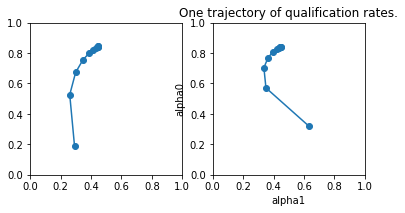

In [11]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()
for k in range(2):
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_un_evolution=[alpha0]
    alpha1_un_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier,
                                                    X, y, sensitive_features, subgroups_indices)
        alpha0_un_evolution.append(alpha0)
        alpha1_un_evolution.append(alpha1)

    plt.subplot(1,2,k+1)
    plt.axis('square')
    plt.plot(alpha1_un_evolution,alpha0_un_evolution,'o-')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.xlabel('alpha1')
plt.ylabel('alpha0')
plt.title("One trajectory of qualification rates.")
plt.show()


7

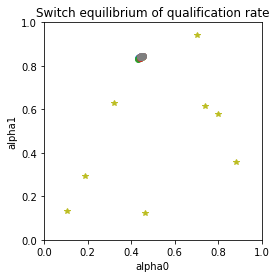

In [40]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()

for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_un_evolution=[alpha0]
    alpha1_un_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier,
                                                    X, y, sensitive_features, subgroups_indices)
        alpha0_un_evolution.append(alpha0)
        alpha1_un_evolution.append(alpha1)
        
    plt.axis('square')
    plt.xlabel('alpha0')
    plt.ylabel('alpha1')
    plt.plot(alpha1_un_evolution[-5:],alpha0_un_evolution[-5:],'o',label='No.'+str(k))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.plot(alpha0List,alpha1List,'*')
plt.title("Switch equilibrium of qualification rate")
plt.show()



### Interprete the equilibrium -- the evolution of qualification rates
- Find the balanced curves

In [10]:
TOTAL_STEP = 50
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)

group0_UN = np.zeros([len(alphaList),len(alphaList)])
group1_UN = np.zeros([len(alphaList),len(alphaList)])

for i, alpha0 in enumerate(alphaList):
    sys.stdout.write("\r{0}".format(str(i)))
    for j, alpha1 in enumerate(alphaList):
        group0_UN[i,j],group1_UN[i,j] = compute_balance_diff(alpha0,alpha1,P0,T,eva_classifier,
                                                             X,y,sensitive_features,subgroups_indices)


49

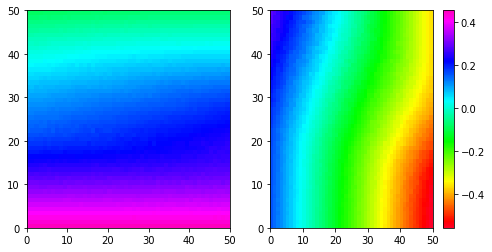

In [19]:
vmin=np.min([group0_UN,group1_UN])
vmax=z_max=np.max([group0_UN,group1_UN])

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(8, 4))

im0 = ax0.pcolormesh(group0_UN, cmap='gist_rainbow',vmin=vmin,vmax=vmax)
im1= ax1.pcolormesh(group1_UN, cmap='gist_rainbow',vmin=vmin,vmax=vmax)

fig.colorbar(im1, ax=ax1)
plt.show()

## DP case

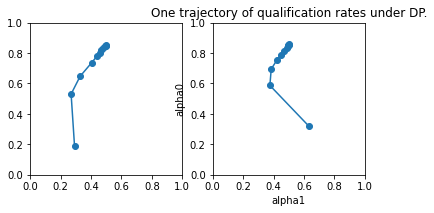

In [31]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()

for k in range(2):
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_dp_evolution=[alpha0]
    alpha1_dp_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier_dp,
                                                        X, y, sensitive_features, subgroups_indices)
        alpha0_dp_evolution.append(alpha0)
        alpha1_dp_evolution.append(alpha1)

    plt.subplot(1,2,k+1)
    plt.axis('square')
    plt.plot(alpha1_dp_evolution,alpha0_dp_evolution,'o-')
    plt.ylim(0, 1)
    plt.xlim(0, 1)

plt.xlabel('alpha1')
plt.ylabel('alpha0')

plt.title("One trajectory of qualification rates under DP.")
plt.show()

In [28]:
TOTAL_STEP = 50
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)
size = len(alphaList)
group0_DP = np.zeros([size, size])
group1_DP = np.zeros([size, size])

for i, alpha0 in enumerate(alphaList):
    sys.stdout.write("\r{0}".format(str(i)))
    for j, alpha1 in enumerate(alphaList):
        group0_DP[i,j],group1_DP[i,j] = compute_balance_diff(alpha0,alpha1,P0,T,eva_classifier_dp,
                                                             X,y,sensitive_features,subgroups_indices)

49

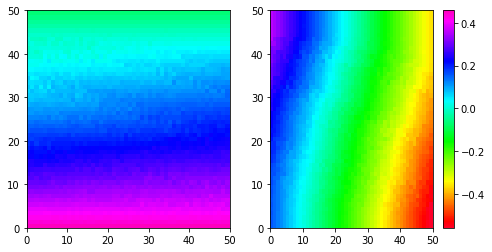

In [29]:
vmin=np.min([group0_DP,group1_DP])
vmax=z_max=np.max([group0_DP,group1_DP])

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(8, 4))

im0 = ax0.pcolormesh(group0_DP, cmap='gist_rainbow',vmin=vmin,vmax=vmax)
im1= ax1.pcolormesh(group1_DP, cmap='gist_rainbow',vmin=vmin,vmax=vmax)

fig.colorbar(im1, ax=ax1)
plt.show()

### EO case

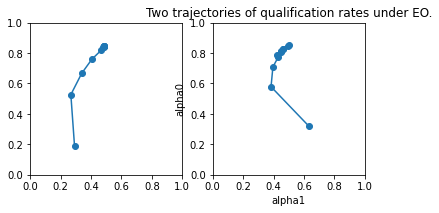

In [33]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()

for k in range(2):
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_eo_evolution=[alpha0]
    alpha1_eo_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier_eo,
                                                        X, y, sensitive_features, subgroups_indices)
        alpha0_eo_evolution.append(alpha0)
        alpha1_eo_evolution.append(alpha1)

    plt.subplot(1,2,k+1)
    plt.axis('square')
    plt.plot(alpha1_eo_evolution,alpha0_eo_evolution,'o-')
    plt.ylim(0, 1)
    plt.xlim(0, 1)

plt.xlabel('alpha1')
plt.ylabel('alpha0')

plt.title("Two trajectories of qualification rates under EO.")
plt.show()

In [34]:
TOTAL_STEP = 50
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)
size = len(alphaList)
group0_eo = np.zeros([size, size])
group1_eo = np.zeros([size, size])

for i, alpha0 in enumerate(alphaList):
    sys.stdout.write("\r{0}".format(str(i)))
    for j, alpha1 in enumerate(alphaList):
        group0_eo[i,j],group1_eo[i,j] = compute_balance_diff(alpha0,alpha1,P0,T,eva_classifier_eo,
                                                             X,y,sensitive_features,subgroups_indices)

49

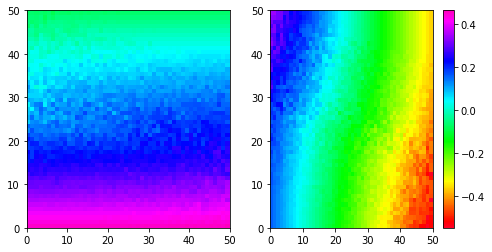

In [35]:
vmin=np.min([group0_eo,group1_eo])
vmax=z_max=np.max([group0_eo,group1_eo])

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(8, 4))

im0 = ax0.pcolormesh(group0_eo, cmap='gist_rainbow',vmin=vmin,vmax=vmax)
im1= ax1.pcolormesh(group1_eo, cmap='gist_rainbow',vmin=vmin,vmax=vmax)

fig.colorbar(im1, ax=ax1)
plt.show()

### EqOpt case

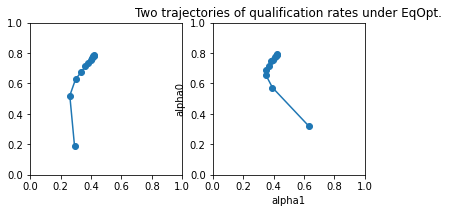

In [37]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()

for k in range(2):
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_eqopt_evolution=[alpha0]
    alpha1_eqopt_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier_eqopt,
                                                        X, y, sensitive_features, subgroups_indices)
        alpha0_eqopt_evolution.append(alpha0)
        alpha1_eqopt_evolution.append(alpha1)

    plt.subplot(1,2,k+1)
    plt.axis('square')
    plt.plot(alpha1_eqopt_evolution,alpha0_eqopt_evolution,'o-')
    plt.ylim(0, 1)
    plt.xlim(0, 1)

plt.xlabel('alpha1')
plt.ylabel('alpha0')

plt.title("Two trajectories of qualification rates under EqOpt.")
plt.show()

In [38]:
TOTAL_STEP = 50
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)
size = len(alphaList)
group0_eqopt = np.zeros([size, size])
group1_eqopt = np.zeros([size, size])

for i, alpha0 in enumerate(alphaList):
    sys.stdout.write("\r{0}".format(str(i)))
    for j, alpha1 in enumerate(alphaList):
        group0_eqopt[i,j],group1_eqopt[i,j] = compute_balance_diff(alpha0,alpha1,P0,T,eva_classifier_eqopt,
                                                             X,y,sensitive_features,subgroups_indices)

49

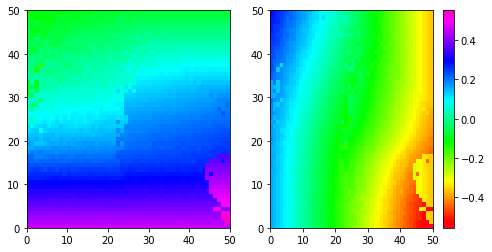

In [39]:
vmin=np.min([group0_eqopt,group1_eqopt])
vmax=z_max=np.max([group0_eqopt,group1_eqopt])

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(8, 4))

im0 = ax0.pcolormesh(group0_eqopt, cmap='gist_rainbow',vmin=vmin,vmax=vmax)
im1= ax1.pcolormesh(group1_eqopt, cmap='gist_rainbow',vmin=vmin,vmax=vmax)

fig.colorbar(im1, ax=ax1)
plt.show()